<a href="https://www.kaggle.com/code/arnabmukherjee853/recommendation-system-amazon-product?scriptVersionId=199786770" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recommendation-system/ratings_Electronics.csv


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [3]:
columns=['UserID','ProductId','Ratings','Timestamp']
df=pd.read_csv('/kaggle/input/recommendation-system/ratings_Electronics.csv',names=columns)
df

,UserID,ProductId,Ratings,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
...,...,...,...,...
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


In [4]:
df.isnull().any()

UserID       False
ProductId    False
Ratings      False
Timestamp    False
dtype: bool

In [5]:
df.drop(columns=['Timestamp'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserID     object 
 1   ProductId  object 
 2   Ratings    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [6]:
df.dtypes

UserID        object
ProductId     object
Ratings      float64
dtype: object

In [7]:
print('Max ratings ',df.Ratings.max())
print('Min rating :',df.Ratings.min())

Max ratings  5.0
Min rating : 1.0


In [8]:
df.Ratings.describe().T

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64

<Axes: >

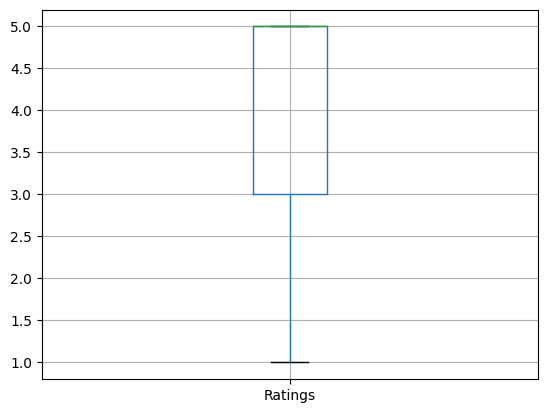

In [9]:
df.boxplot()

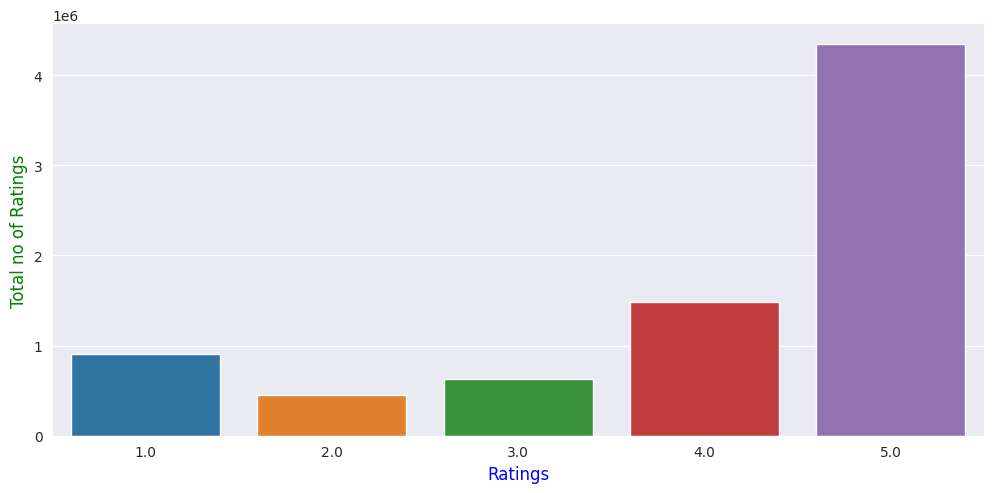

(None,)

In [10]:
with sns.axes_style('darkgrid'):
    A=sns.catplot(x='Ratings',data=df,kind='count',aspect=2.0)
    A.set_ylabels('Total no of Ratings',fontsize=12,color='green')
    A.set_axis_labels('Ratings',fontsize=12,color='blue')
plt.show(),

In [11]:
print('Number of unique users: ', df.UserID.nunique())
print('NUmber of unique products: ', df.ProductId.nunique())

Number of unique users:  4201696
NUmber of unique products:  476002


**Checking to 25 users based on ratings**

In [12]:
df.head(3)

,UserID,ProductId,Ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0


In [13]:
top_rated=df.groupby('UserID').size().sort_values(ascending=False)[:25]
print('Top 25 user based on ratings',top_rated)

Top 25 user based on ratings UserID
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
ARBKYIVNYWK3C     296
A22CW0ZHY3NJH8    292
A3EXWV8FNSSFL6    282
A38RMU1Y5TDP9     282
A3LGT6UZL99IW1    279
A2NOW4U7W3F7RI    277
A23GFTVIETX7DS    270
A3PD8JD9L4WEII    266
A17BUUBOU0598B    261
A3AYSYSLHU26U9    257
A2XRMQA6PJ5ZJ8    253
A12DQZKRKTNF5E    252
A231WM2Z2JL0U3    252
A1UQBFCERIP7VJ    247
AGVWTYW0ULXHT     244
dtype: int64


In [14]:
counts=df.UserID.value_counts()
df1=df[df.UserID.isin(counts[counts>=50].index)]
print("No of users who rated more than 50 times: ", len(df1))
print("No of unique users: ", df1.UserID.nunique())
print("No of unique products: ", df1.ProductId.nunique())

No of users who rated more than 50 times:  125871
No of unique users:  1540
No of unique products:  48190


df1 has the user who have rated atleast 50 items.

In [15]:
final_rating_matrix=df1.pivot(index='UserID',columns='ProductId',values='Ratings').fillna(0)
final_rating_matrix

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZBXKUH4AIW3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZCE11PSTCH1L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZMY6E8B52L2T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("Shape of final rating matrix: ",final_rating_matrix.shape)

Shape of final rating matrix:  (1540, 48190)


In [17]:
given_num_of_rating=np.count_nonzero(df1)
print('Given number of ratings: ',given_num_of_rating)
possible_num_of_ratings=final_rating_matrix.shape[0]*final_rating_matrix.shape[1]
print('Possible number of ratings: ',possible_num_of_ratings)
density=given_num_of_rating/possible_num_of_ratings
density *=100
print('density: {:4.2f}%'.format(density))

Given number of ratings:  377613
Possible number of ratings:  74212600
density: 0.51%


In [18]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df1,test_size=.25,random_state=42)
train.head()
print('Shape of training data',train.shape)
print('Shape of testing data',test.shape)

,UserID,ProductId,Ratings
7365368,A1VQHH85U7PX0,B00D6XW62I,5.0
3072401,A1IU7S4HCK1XK0,B0035JJJQY,2.0
2902202,AVPNQUVZWMDSX,B002VPE1Y8,5.0
3526416,A3FEGTOLCWXSV4,B003RRYAXQ,4.0
6672829,A3MUSWDCTZINQZ,B009O7XGMO,4.0


Shape of training data (94403, 3)
Shape of testing data (31468, 3)


**Popularity Recommender Model**

In [19]:
train

,UserID,ProductId,Ratings
7365368,A1VQHH85U7PX0,B00D6XW62I,5.0
3072401,A1IU7S4HCK1XK0,B0035JJJQY,2.0
2902202,AVPNQUVZWMDSX,B002VPE1Y8,5.0
3526416,A3FEGTOLCWXSV4,B003RRYAXQ,4.0
6672829,A3MUSWDCTZINQZ,B009O7XGMO,4.0
...,...,...,...
7632788,A2AY4YUOX2N1BQ,B00FFJDYHM,5.0
6623572,A2NOW4U7W3F7RI,B009HE34SA,5.0
50361,A2HPJKM7L4EOQB,B00004TKWI,5.0
805845,A1UMSB7LAW0RIR,B000CMS5B2,5.0


In [20]:
training_data_grouped=train.groupby('ProductId')['UserID'].agg( 'count').reset_index()
training_data_grouped.rename(columns={'UserID':'Score'},inplace=True)
training_data_grouped.head(25)

,ProductId,Score
0,0594481813,1
1,0970407998,1
2,0972683275,4
3,1400501466,6
4,1400501520,1
5,1400501776,2
6,1400532620,2
7,1400532655,5
8,140053271X,2
9,1400599997,4


Count of userid for each unique product as recommendation score.

In [21]:
training_data_sorted=training_data_grouped.sort_values(['Score','ProductId'],ascending=[0,1])

# Generating a recommendation rank based on score.
training_data_sorted['Rank']=training_data_sorted['Score'].rank(ascending=0,method='first')

# Top 5 Recommendations
popularity_recommendation = training_data_sorted.head()
popularity_recommendation

,ProductId,Score,Rank
32359,B0088CJT4U,153,1.0
20531,B003ES5ZUU,136,2.0
31765,B007WTAJTO,135,3.0
9086,B000N99BBC,124,4.0
32054,B00829TIEK,110,5.0


In [22]:
# Using popularity based recommendation model to make predictions
def recommend(userid):
    user_recommendation = popularity_recommendation
    # Adding user id column for which the recommendations will be generated.
    user_recommendation['userid'] = userid
    # Bringing 'userid' column to the front while keeping other columns in the same position.
    cols = user_recommendation.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendation = user_recommendation[cols]
    return user_recommendation

> Since, it is a Popularity based recommender model, so, all the three users will be given same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

In [23]:
user_list = [15,25,123]
for i in user_list:
    print("The list of Recommendations for the userid : ",i)
    print(recommend(i))
    print("\n")

The list of Recommendations for the userid :  15
       userid   ProductId  Score  Rank
32359      15  B0088CJT4U    153   1.0
20531      15  B003ES5ZUU    136   2.0
31765      15  B007WTAJTO    135   3.0
9086       15  B000N99BBC    124   4.0
32054      15  B00829TIEK    110   5.0


The list of Recommendations for the userid :  25
       userid   ProductId  Score  Rank
32359      25  B0088CJT4U    153   1.0
20531      25  B003ES5ZUU    136   2.0
31765      25  B007WTAJTO    135   3.0
9086       25  B000N99BBC    124   4.0
32054      25  B00829TIEK    110   5.0


The list of Recommendations for the userid :  123
       userid   ProductId  Score  Rank
32359     123  B0088CJT4U    153   1.0
20531     123  B003ES5ZUU    136   2.0
31765     123  B007WTAJTO    135   3.0
9086      123  B000N99BBC    124   4.0
32054     123  B00829TIEK    110   5.0




**Building Collaborative Filtering recommender model.**

In [24]:
electronics_df_cf=pd.concat([train,test]).reset_index()
electronics_df_cf.head()

,index,UserID,ProductId,Ratings
0,7365368,A1VQHH85U7PX0,B00D6XW62I,5.0
1,3072401,A1IU7S4HCK1XK0,B0035JJJQY,2.0
2,2902202,AVPNQUVZWMDSX,B002VPE1Y8,5.0
3,3526416,A3FEGTOLCWXSV4,B003RRYAXQ,4.0
4,6672829,A3MUSWDCTZINQZ,B009O7XGMO,4.0


User based Collaborative Filtering model

In [25]:
pivot_df = electronics_df_cf.pivot(index='UserID',columns='ProductId',values='Ratings').fillna(0)
pivot_df.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Using Singular Value Decomposition

In [26]:
# Converting the sparse matrix into a numpy array.
pivot_array = pivot_df.to_numpy()

# performing Singular Value Decomposition on the array taking top 15 hidden features.

U,sigma,Vt = svds(pivot_array,k=15)

In [27]:
print('Left Singular matrix: \n',U)

Left Singular matrix: 
 [[ 0.00817592  0.01961794 -0.00339779 ... -0.02098223 -0.03450332
  -0.02112691]
 [ 0.02191483  0.00302331 -0.02226907 ... -0.01076097  0.02009915
  -0.03863719]
 [-0.00144373  0.01359724  0.00757338 ...  0.02924332  0.03319807
  -0.03354122]
 ...
 [ 0.09424024 -0.07215553 -0.08848905 ... -0.01332978 -0.1613707
  -0.05949368]
 [-0.00869957 -0.00719075 -0.00346235 ... -0.00677598  0.00445708
  -0.01348483]
 [ 0.00565055 -0.00942571 -0.01040381 ... -0.01215862 -0.00249329
  -0.00561029]]


In [28]:
print('Right singular matrix : \n',Vt)

Right singular matrix : 
 [[-7.45663338e-05 -1.13356811e-04 -4.27103354e-04 ... -3.04058823e-02
  -2.20041938e-03  9.15329704e-04]
 [ 4.54159353e-05 -8.24730368e-04  1.01268425e-03 ... -5.63560361e-03
   1.88397601e-03  8.88125562e-04]
 [ 6.61282559e-05 -1.90458139e-04  3.02447206e-03 ...  8.54699839e-03
  -5.83676175e-03  7.93701928e-04]
 ...
 [-8.81590303e-04 -1.31370545e-03 -4.21874643e-04 ...  1.37986535e-02
   4.52761832e-03 -1.09691626e-03]
 [-4.58579287e-05 -1.88881713e-04 -9.00497985e-05 ... -3.32629345e-02
  -1.31262740e-02 -2.24988359e-03]
 [-2.02226218e-04 -2.59177123e-04 -6.62049181e-04 ... -1.02695130e-02
  -3.76431121e-03 -8.69030592e-04]]


In [29]:
print('Sigma: \n',sigma)

Sigma: 
 [ 79.39214749  80.2967454   80.95856309  82.19795763  83.3788163
  87.43474122  88.68897677  91.15027972  92.15989229  95.03789667
  98.21626326 100.38232831 107.7090351  119.69501814 182.29276718]


In [30]:
print('Shape of Leftt Singular Matrix is: \n',U.shape)
print('Shape of Right Singular Matrix is: \n',Vt.shape)
print('Shape of Sigma is: \n',sigma.shape)

Shape of Leftt Singular Matrix is: 
 (1540, 15)
Shape of Right Singular Matrix is: 
 (15, 48190)
Shape of Sigma is: 
 (15,)


> Converting Sigma into a diagonal matrix

In [31]:
sigma = np.diag(sigma)
print(sigma.shape)

(15, 15)


In [32]:
sigma

array([[ 79.39214749,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,  80.2967454 ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  80.95856309,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  82.19795763,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.  

* **Left Singular Vectors**: "U" defines each user preferences accross each hidden features "sigma"; **User profiling**.
* **Singular Values**:  "sigma" defines the **hidden features** 15 in this case. it is a diagonal matrix of size (k x k). selection of k values also used a dimentionality reduction technique which sorts our user-item interaction matrix which scale down our whole matrix into the most relevent hidden features. **"sigma" is the square root of the eigen values of A(Transpose)A**, A is user-item interaction matrix.
* **Right Singular Vectors Transposed**: "Vt" is the transpose of a orthogonal matrix "V" which defines each item interaction with those hidden features "sigma", e.g. one movie might strongly correlate with action and adventure, while another may correlate more with romance and drama; **Item Profiling**.

**Reconstructing the user-item interaction matrix with predicted ratings of unknown user-item interaction pairs**

> R(i,j)= Ui sigma VjT

In [33]:
all_user_predicted_ratings = np.dot(np.dot(U,sigma),Vt)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns= pivot_df.columns)
preds_df

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002401,0.002269,0.000755,0.009067,0.003836,0.001468,0.009426,0.001807,0.017635,0.001420,...,0.000497,0.056702,0.005682,0.074960,-0.001004,0.006642,0.001533,0.087144,0.070098,0.020395
1,0.001591,0.002444,-0.006819,0.027309,0.007947,-0.002116,0.016936,0.001579,0.000832,-0.001719,...,0.000012,0.045945,0.002539,0.018081,0.000348,-0.000555,0.005651,-0.130497,0.012290,0.010164
2,-0.001402,-0.003468,0.006353,0.012991,0.006091,-0.001456,0.006106,0.003700,-0.005473,-0.001027,...,-0.000285,0.014047,-0.001838,-0.012389,0.018440,-0.002690,-0.000782,0.005426,-0.014821,-0.004834
3,0.002659,0.004796,-0.000707,0.011495,0.003958,0.002605,0.002122,-0.000309,0.007696,0.002259,...,0.000670,-0.000854,0.002603,-0.002821,-0.001639,0.000224,0.002948,-0.014943,-0.005079,0.001514
4,0.000623,-0.000563,0.001383,0.009127,0.003551,0.000158,0.007431,0.001595,0.001348,0.000315,...,0.000103,0.014204,0.001221,-0.011674,0.002183,-0.002300,0.000687,-0.059538,-0.010437,-0.001540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,0.002218,0.004501,-0.001520,0.014087,0.003987,0.001636,0.001627,-0.000061,0.006028,0.001392,...,0.000266,-0.011036,0.001322,-0.011101,0.003644,0.000462,0.004073,-0.007941,-0.003605,0.001512
1536,0.001692,0.003176,0.001255,0.009643,0.002492,0.001920,0.000848,0.000008,0.004598,0.001645,...,0.000335,0.005816,0.001337,0.005326,0.000325,0.000603,0.002538,-0.005285,-0.003124,0.002208
1537,0.001843,0.009482,-0.034425,0.031667,-0.002630,-0.006146,0.011962,-0.005741,0.031206,-0.005126,...,-0.000516,0.264940,0.004248,0.293749,-0.016336,0.031602,0.004791,0.224173,0.331626,0.059899
1538,0.000739,0.002232,-0.001067,0.005993,0.002101,0.000559,0.002953,0.000190,0.010630,0.000526,...,0.000231,0.006293,0.000168,-0.000072,-0.001252,0.000604,0.002261,0.012132,0.009956,-0.000030


In [34]:
pivot_df

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZBXKUH4AIW3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZCE11PSTCH1L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZMY6E8B52L2T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
pivot_df.iloc[51]

ProductId
0594451647    0.0
0594481813    0.0
0970407998    0.0
0972683275    0.0
1400501466    0.0
             ... 
B00LED02VY    0.0
B00LGN7Y3G    0.0
B00LGQ6HL8    0.0
B00LI4ZZO8    0.0
B00LKG1MC8    0.0
Name: A145B8OHVNNFAJ, Length: 48190, dtype: float64

In [36]:
def Recommend_items(userID,pivot_df,preds_df,num_recommendations):
    user_ids = userID-1
    sorted_user_ratings = pivot_df.iloc[user_ids].sort_values(ascending=False)
    sorted_user_predictions = preds_df.iloc[user_ids].sort_values(ascending=False)
    temp = pd.concat([sorted_user_ratings,sorted_user_predictions],axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['User_Ratings','User Predictions']
    temp = temp.loc[temp.User_Ratings==0]
    temp = temp.sort_values('User Predictions',ascending=False)
    print(f'\nThese are the Recommended Items for user id = {userID}')
    print(temp.head(num_recommendations))

In [37]:
userID =123
num_recommendations = 5
Recommend_items(userID,pivot_df,preds_df,num_recommendations)


These are the Recommended Items for user id = 123
                   User_Ratings  User Predictions
Recommended Items                                
B007WTAJTO                  0.0          0.889701
B000N99BBC                  0.0          0.675375
B003ES5ZUU                  0.0          0.628101
B001TH7GUU                  0.0          0.593371
B002V88HFE                  0.0          0.555224


In [38]:
userID = 15
num_recommendations = 5
Recommend_items(userID,pivot_df,preds_df,num_recommendations)


These are the Recommended Items for user id = 15
                   User_Ratings  User Predictions
Recommended Items                                
B007WTAJTO                  0.0          0.202108
B003ES5ZUU                  0.0          0.169598
B002V88HFE                  0.0          0.153699
B000QUUFRW                  0.0          0.134437
B001TH7GUU                  0.0          0.112102


In [39]:
userID = 25
num_recommendations = 5
Recommend_items(userID,pivot_df,preds_df,num_recommendations)


These are the Recommended Items for user id = 25
                   User_Ratings  User Predictions
Recommended Items                                
B003ES5ZUU                  0.0          0.939556
B007WTAJTO                  0.0          0.851823
B002V88HFE                  0.0          0.469039
B002WE6D44                  0.0          0.403839
B005CT56F8                  0.0          0.402813


In [40]:
print(final_rating_matrix.shape)

(1540, 48190)


In [41]:
final_rating_matrix.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
final_rating_matrix.mean().head()

ProductId
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [43]:
preds_df.mean().head()

ProductId
0594451647    0.001565
0594481813    0.002308
0970407998    0.003073
0972683275    0.011503
1400501466    0.004863
dtype: float64

In [44]:
rmse_df = pd.concat([final_rating_matrix.mean(),preds_df.mean()],axis=1)
rmse_df.columns = ['Avg_Actual_Ratings','Avg_predicted_ratings']
rmse_df.head()

,Avg_Actual_Ratings,Avg_predicted_ratings
ProductId,,
0594451647,0.003247,0.001565
0594481813,0.001948,0.002308
0970407998,0.003247,0.003073
0972683275,0.012338,0.011503
1400501466,0.012987,0.004863


In [45]:
print(rmse_df.shape)

(48190, 2)


In [46]:
RMSE = round((((rmse_df.Avg_Actual_Ratings - rmse_df.Avg_predicted_ratings)**2).mean()**0.5),5)
print(f'\nRMSE of SVD Model is: {RMSE}')


RMSE of SVD Model is: 0.00327


**Using additional Collaborative filtering models from Surprise module.**

In [47]:
df.head()

,UserID,ProductId,Ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [48]:
rts_gp = df.groupby('Ratings')['UserID'].count().reset_index()

In [49]:
rts_gp.columns=['Ratings','Count']
rts_gp

,Ratings,Count
0,1.0,901765
1,2.0,456322
2,3.0,633073
3,4.0,1485781
4,5.0,4347541


In [50]:
# Products having atleast 50 ratings
prod_ge_50 = df.groupby('ProductId').filter(lambda x:x['Ratings'].count() >= 50)
prod_ge_50

,UserID,ProductId,Ratings
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0
...,...,...,...
7824223,A2857SW4TZ841C,B00L3YHF6O,1.0
7824224,A2Y2NSH2HVFAOA,B00L3YHF6O,5.0
7824225,A3TC2716OF7HK8,B00L3YHF6O,5.0
7824226,AYCPSPX7XZ21G,B00L3YHF6O,5.0


In [51]:
# User who have given atleast 50 ratings
user_ge_50 = df.groupby('UserID').filter(lambda x:x['Ratings'].count() >= 50)
user_ge_50

,UserID,ProductId,Ratings
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0
...,...,...,...
7824426,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0
7824427,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0
7824436,A3AYSYSLHU26U9,B00LI4ZZO8,4.0
7824438,A2NYK9KWFMJV4Y,B00LI4ZZO8,5.0


In [52]:
user_ge_50.drop(['Ratings'],inplace=True,axis=1)

**

**Recontructing the dataframe with users and items satisfying the filtering conditions**

In [53]:
user_prod_ge = pd.merge(prod_ge_50,user_ge_50)

In [54]:
user_prod_ge

,UserID,ProductId,Ratings
0,A3CLWR1UUZT6TG,0972683275,5.0
1,A3TAS1AG6FMBQW,0972683275,5.0
2,A2Y4H3PXB07WQI,0972683275,4.0
3,A25RTRAPQAJBDJ,0972683275,5.0
4,A3LDPF5FMB782Z,1400501466,5.0
...,...,...,...
79177,A3R1WFO4KIUQXZ,B00L3YHF6O,5.0
79178,A3S3R88HA0HZG3,B00L3YHF6O,5.0
79179,A2XRMQA6PJ5ZJ8,B00L3YHF6O,5.0
79180,A3A4ZAIBQWKOZS,B00L3YHF6O,5.0


In [55]:
import surprise
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF

In [56]:
# setting rating scale upto 5
reader = Reader(rating_scale=(1,5))
#Loading data with rating scale
data = Dataset.load_from_df(user_prod_ge,reader,)

In [57]:
knnbasic_cv = cross_validate(KNNBasic(k=35),data,cv=10,n_jobs=5,verbose=True)
knnmeans_cv = cross_validate(KNNWithMeans(k=35),data,cv=10,n_jobs=5,verbose=True)
knnzs_cv = cross_validate(KNNWithZScore(k=35),data,cv=10,n_jobs=5,verbose=True)
svd_cv = cross_validate(SVD(), data, cv=10, n_jobs=5, verbose=True)
svdpp_cv = cross_validate(SVDpp(),data,cv=10,n_jobs=5,verbose=True)
nmf_cv = cross_validate(NMF(),data,cv=10,n_jobs=5,verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.0917  1.1192  1.1133  1.1008  1.1078  1.0884  1.0851  1.1110  1.0730  1.1022  1.0993  0.0137  
MAE (testset)     0.7629  0.7797  0.7750  0.7708  0.7716  0.7593  0.7556  0.7720  0.7519  0.7687  0.7668  0.0085  
Fit time          0.21    0.27    0.26    0.20    0.19    0.13    0.18    0.23    0.21    0.17    0.20    0.04    
Test time         0.73    0.65    0.50    0.44    0.42    0.46    0.52    0.49    0.42    0.41    0.50    0.10    
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.0259  1.0355  1.0426  1.0564  1.0145  1.0504  1.0232  1.0443  1.0255  1.0444  1.0363  0.0128  
MAE (testset)     0.7178  0.7227  0.7274  0.7360  0.7156  0.7355  0.714

In [58]:
print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(knnzs_cv['test_rmse'].mean(), 4), '\t', round(knnzs_cv['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()

Algorithm	 RMSE		 MAE

KNN Basic 	 1.0993 	 0.7668
KNN Means 	 1.0363 	 0.7248
KNN ZScore 	 1.0428 	 0.7208

SVD 		 0.9577 	 0.7016
SVDpp 		 0.9569 	 0.6947
NMF 		 1.1224 	 0.8439



In [59]:
knnbasic_cv

{'test_rmse': array([1.09166662, 1.11915825, 1.11333988, 1.10082204, 1.10784593,
        1.08841042, 1.08508304, 1.11098182, 1.07299751, 1.10224331]),
 'test_mae': array([0.76288063, 0.77972476, 0.77497649, 0.77076818, 0.77164026,
        0.75928137, 0.75561874, 0.77204728, 0.75192803, 0.76870898]),
 'fit_time': (0.20597124099731445,
  0.2667090892791748,
  0.26108837127685547,
  0.20233464241027832,
  0.18571114540100098,
  0.12959074974060059,
  0.17785310745239258,
  0.23022794723510742,
  0.212935209274292,
  0.170396089553833),
 'test_time': (0.7310941219329834,
  0.6540985107421875,
  0.5001735687255859,
  0.43575143814086914,
  0.4191863536834717,
  0.46346306800842285,
  0.5169234275817871,
  0.4853382110595703,
  0.41802406311035156,
  0.40527892112731934)}

<Figure size 2000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Comparison of Algorithms on RMSE')

Text(0.5, 0, 'Algorithms')

Text(0, 0.5, 'RMSE Value')

<Axes: >

Text(0.5, 1.0, 'Comparison of Algorithms on MAE')

Text(0.5, 0, 'Algorithms')

Text(0, 0.5, 'MAE Value')

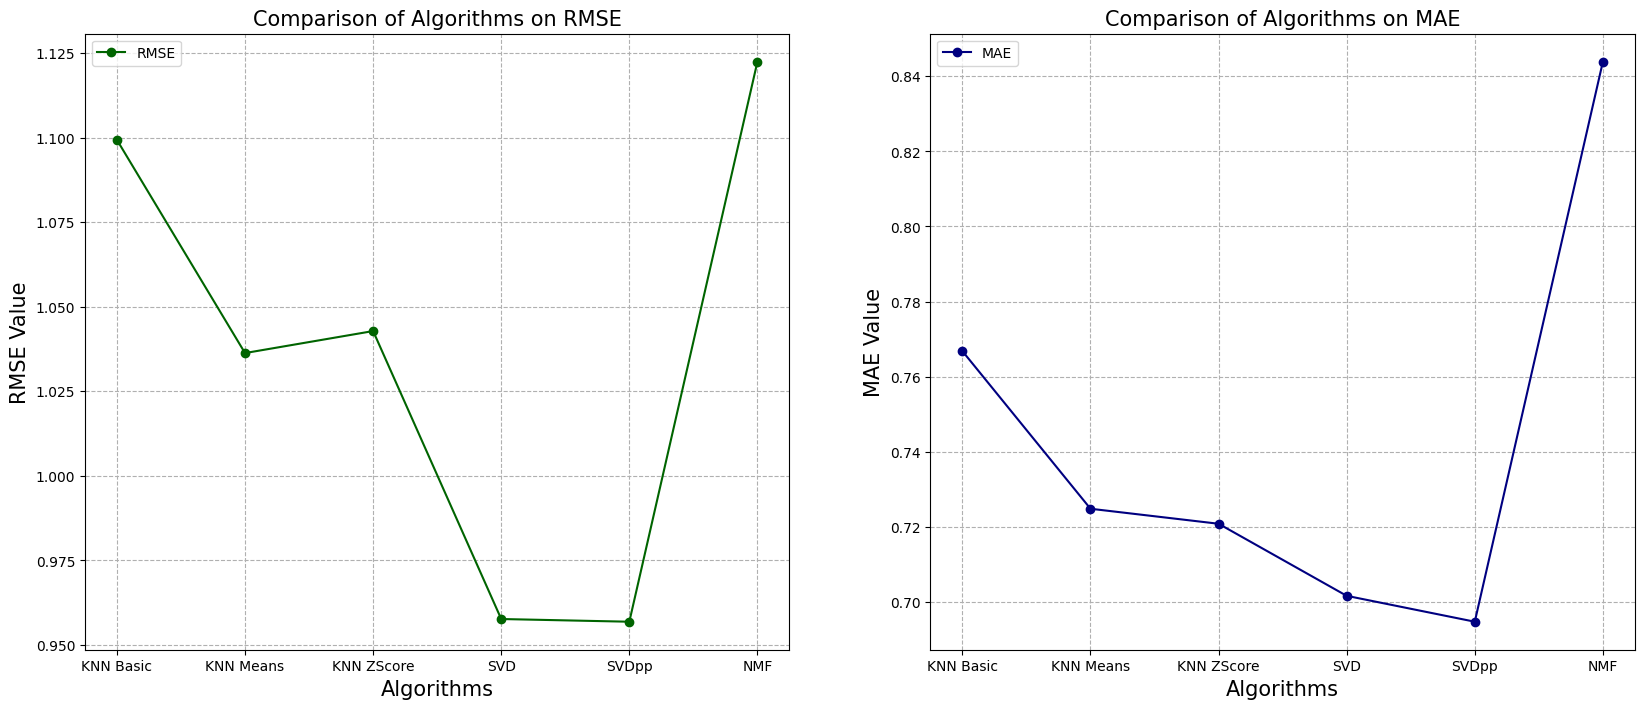

In [60]:

x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp', 'NMF']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnzs_cv, svd_cv, svdpp_cv, nmf_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

In [61]:
raw_ratings = data.raw_ratings                         # 90% trainset, 10% testset
threshold = int(.9 * len(raw_ratings))
trainset_raw_ratings = raw_ratings[:threshold]
test_raw_ratings = raw_ratings[threshold:]
data.raw_ratings = trainset_raw_ratings

In [62]:
from surprise import accuracy

# Parameter space
svd_param_grid = {'n_epochs': [20, 25],
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}

svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=10, n_jobs=5)
svdpp_gs.fit(data)
algo_svdpp = svdpp_gs.best_estimator['rmse']
# retrain on the whole train set
#
trainset = data.build_full_trainset()
algo_svdpp.fit(trainset)
# now test on the trainset
testset = data.construct_testset(trainset_raw_ratings)
predictions_train = algo_svdpp.test(testset)
print('Accuracy on the trainset:')
accuracy.rmse(predictions_train)

# now test on the testset
testset = data.construct_testset(test_raw_ratings)
pred_svdpp=algo_svdpp.test(testset)
print('Accuracy on the testset:')
accuracy.rmse(pred_svdpp)


svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=10, n_jobs=5)
svd_gs.fit(data)
algo_svd = svd_gs.best_estimator['rmse']
# retrain on the whole train set
trainset = data.build_full_trainset()
algo_svd.fit(trainset)
# now test on the trainset
testset = data.construct_testset(trainset_raw_ratings)
predictions_train = algo_svd.test(testset)
print('Accuracy on the trainset:')
accuracy.rmse(predictions_train)

# now test on the testset
testset = data.construct_testset(test_raw_ratings)
pred_svd=algo_svd.test(testset)
print('Accuracy on the testset:')
accuracy.rmse(pred_svd)

Accuracy on the trainset:
RMSE: 0.8663


0.8663285088987512

Accuracy on the testset:
RMSE: 0.8796


0.8795840869165525

Accuracy on the trainset:
RMSE: 0.8431


0.8431143677633841

Accuracy on the testset:
RMSE: 0.8799


0.8798948283181306

In [63]:
print('SVDpp - RMSE:', round(svdpp_gs.best_score['rmse'], 4), '; MAE:', round(svdpp_gs.best_score['mae'], 4))
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 4), '; MAE:', round(svd_gs.best_score['mae'], 4))
print('RMSE =', svdpp_gs.best_params['rmse'])
print('MAE =', svdpp_gs.best_params['mae'])
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])

SVDpp - RMSE: 0.9645 ; MAE: 0.7154
SVD   - RMSE: 0.9641 ; MAE: 0.7144
RMSE = {'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.4}
MAE = {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}
RMSE = {'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.4}
MAE = {'n_epochs': 25, 'lr_all': 0.009, 'reg_all': 0.4}


In [64]:
from collections import defaultdict
def get_top_n_recommendations(reccomemndations, n=5):
    # Mapping the reccommendations to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in reccomemndations:
        top_n[uid].append((iid, est))

    #sorting predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [65]:
top_5 = get_top_n_recommendations(pred_svd, n=5)
for uid, user_ratings in top_5.items():
    print(uid, [iid for (iid, _) in user_ratings])

AGVWTYW0ULXHT ['B00BOHNYU6', 'B00CIY0KOM', 'B00CQJUT9U', 'B00CRXZSYQ', 'B00CSFCYFY']
AIJQU979J6UFY ['B00BOHNYU6', 'B00BT8XX9C', 'B00C28L51G', 'B00CB2F65O', 'B00CDGSNKS']
A19NP8YYADOOSF ['B00BOHNYU6', 'B00BPHH8MA', 'B00C8OT7FK', 'B00CL8F98W', 'B00D3F7D7M']
ASJZT7DM51QEM ['B00BOHNYU6', 'B00CB2F65O', 'B00COF7DGS', 'B00D96LZ6K', 'B00DHPCVQG']
A2XPK6XCL0UH1S ['B00BOHNYU6', 'B00FXYT12G']
AX7317G153T8W ['B00BOHNYU6', 'B00BQ5RY1G', 'B00CEB5QU2', 'B00EU9V3VW', 'B00F3F0EIU']
A12ANFNOSMW5VD ['B00BOHNYU6', 'B00IL7B2YM']
A21I62TCDL4754 ['B00BOHNYU6', 'B00F5NB7MW', 'B00FAMAQQG']
AELK0E5DK7LIZ ['B00BOHNYU6', 'B00BQ4F9ZA', 'B00BWX2OU8', 'B00C9TECFO', 'B00CL8F98W']
A1RDHBBZE1NPS3 ['B00BOHNYU6', 'B00BQ5RY1G', 'B00BUJ6MW0', 'B00CIRLJPI', 'B00D1GYNT4']
A2J8T58Z4X15IO ['B00BOHNYU6', 'B00CB2F65O', 'B00CKAOJA0', 'B00CYX54C0', 'B00CZ6WAEQ']
A11I1I9QLMAM1A ['B00BOHNYU6', 'B00BPHH8MA', 'B00BQ5RY1G', 'B00BQ5RYI4', 'B00C28L138']
A37D1ZP8GBHE38 ['B00BOHNYU6', 'B00CRJWW2G', 'B00DY2Y28M', 'B00EH5UGR6', 'B00F6E8OUS']

**Summarising insights**
* The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 15, 25 & 123, The Popularity based model has recommended the same set of 5 products to them but Collaborative Filtering based model has recommended entirely different list of items based on the user's past purchase history.

* Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

**Observations**
* The Popularity-based recommender system is a non-personalized recommender system and these are based on frequency counts, which may be not suitable to the user.
* Model-based Collaborative Filtering is a personalized recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.
* Item Similarity Based model performed worse than even simple popularity based models. Best performing models is SVDpp (RMSE : 0.9641)
* Hyper parameter tuning with GridSearch didn't improve model performance.